In [69]:
import numpy as np
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# %load Fobos.py

In [645]:
# %load Fobos.py
class FOBOS (BaseEstimator):
    '''
    FOBOS composite mirror descent
    
    The implementation of the FOBOS algorithm has been inspired from formulas present
    in the slides:
        https://stanford.edu/~jduchi/projects/DuchiSi09c_slides.pdf
    and the paper:
        https://stanford.edu/~jduchi/projects/DuchiSi09c.pdf
    

    At each timestamp t, we observe the couple (x_t, y_t)
    
    Arguments
    *********
    dimension: dimension of the observed variables + 1 (for bias)
    loss: either 'least_squares' (for regression) or 'logloss' (for classification)
    initial_step: the initial learning rate used for the descent. This parameter
                  has a huge impact on performance of the algorithm and must be
                  tuned efficiently.
    lamda1: regularization coefficient for the l1 penalty (only used when
            regularization = 'l1' or 'elasticNet')
    lamda2: regularization coefficient for the l2 penalty (only used when
            regularization = 'l2' or 'elasticNet')
    regularization: either 'l1' or 'l2' or 'elasticNet'
    initialization: coefficient vector initialization. It's either 'zeros' or 'random'
    with_log: boolean to keep a trace of coefficients and gradient norms or not when
              fitting data.
              
    Note
    ****
    In the case of linear regression, the least_squares loss is chosen, and therefore,
    we're minimizing this loss at each iteration:
        loss(x_t, y_t) = 0.5*(<x_t,w_t> - y_t)^2
            (with <a,b> denotes the dot product between vectors a and b)
            
    The gradient of this loss with respect to the coefficients vector w_t is:
        grad_lsloss(x_t, y_t) = x_t*(<x_t,w_t> - y_t)
        
    The prediction function in this case is:
        pred(x_t) = <w_t, x_t>
        
    
    In the case of logistic regression, the logloss is chosen and we'll minimize instead
    this loss:
        loss(x_t, y_t) = log(1 + exp(-y_t.<x_t, w_t>))
    
    Its gradient with respect to w_t:
        grad_logloss(x_t, y_t) = 1/(1+ exp(y_t<x_t, w_t>))
        
    PS: y_t in the classification case needs to be -1 or +1, therefore corresponding
        mapping between -1 and 0 has been done in the case the class value which is
        fitted is 0 instead of -1. A reverse mapping also has been done for prediction.
        
    '''
    def __init__(self, loss='least_squares', initial_step=.1, lamda1= 1e-3,
                  lamda2=1e-3, regularization='l1', initialization='zeros', with_log=False,):

        self.yflag = False
        self.t = 0 #number of learned points
        self.regularization = regularization
        self.lamda1 = lamda1
        self.lamda2 = lamda2
        self.initial_step = initial_step
        self.learning_rate = initial_step
        self.p = -1
        self.initialization = initialization

        self.soft_thresholding = np.vectorize(self.soft_thresholding_scalar)
        if loss == 'least_squares':
            self.pred = self.predict_regression
            self.grad = self.gradient_lse
        elif loss == 'logloss':
            self.pred = self.predict_classif
            self.grad = self.gradient_logreg
        
        self.with_log = with_log
        if with_log:
            self.gradlog = []
            self.wlog = []
    def reshape_x(self, x_t):
        x_t = np.concatenate([x_t,np.ones(1)])
        
        return x_t
    
    def initialize(self):
        if self.initialization == 'zeros':
            self.w = np.zeros(self.p)
        else:
            self.w = np.random.randn(self.p)

    def fit(self, x_t, y_t):
        if self.p == -1:
            if np.ndim(x_t) == 1:
                self.p = np.shape(x_t)[0] + 1
            else:
                self.p = np.shape(x_t)[1] + 1
            self.initialize()
        
        x_t = self.reshape_x(x_t)
        self.t += 1
        self.learning_rate = self.initial_step / np.sqrt(self.t)
        w_thalf = self.w - self.learning_rate * self.grad(x_t, y_t)

        if self.regularization == 'l1':
            self.w = self.soft_thresholding(w_thalf, self.lamda1*self.learning_rate)
        elif self.regularization == 'l2':
            self.w = w_thalf/(1 + self.lamda2*self.learning_rate)
        elif self.regularization == 'elasticNet':
            self.w = self.soft_thresholding(w_thalf, self.lamda1*self.learning_rate) / (1 + self.lamda2*self.learning_rate)
        if self.with_log:
            self.wlog.append(self.w)
    
    def predict(self, x_t):
        x_t = self.reshape_x(x_t)
        return pred(x_t)


    def soft_thresholding_scalar(self, x, lamda):
        return np.sign(x) * np.maximum(0, np.abs(x) - lamda)


    def gradient_lse(self, x_t, y_t):
        if self.with_log:
            self.gradlog.append(np.linalg.norm(x_t * (x_t.dot(self.w) - y_t)))
        return x_t * (x_t.dot(self.w) - y_t)
    

    def gradient_logreg(self, x_t, y_t):
        if y_t == 0:
            y_t = -1
            self.yflag = True
        exp = np.exp(y_t * x_t.dot(self.w))
        
        return -y_t * x_t / (1+exp)


    def predict_regression(self, x_t):
        return self.w.dot(x_t)
    
    def predict_classif(self, x_t):
        y = np.sign(predict_regression(x_t))
        if self.yflag and (y + 1) < 1e-10:
            y = 0
        
        return y

In [637]:
len(np.array([[1,2,3],[2,2,2]]))

2

In [578]:
x = np.linspace(1,100, 100)
x = np.reshape(x, [100,1])

### ** Let's try to test it on Toy dataset:**

In [555]:
y = 2*x 

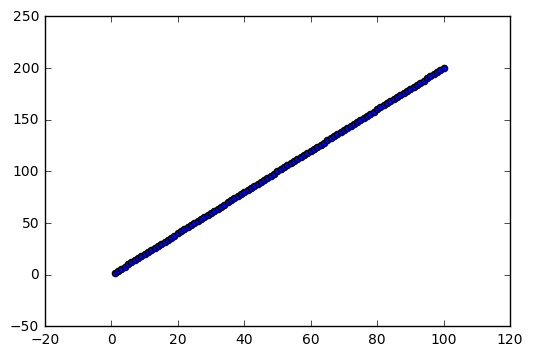

In [556]:
plt.scatter(x, y)

In [558]:
fobos = FOBOS(initialization='random', lamda2=1e-2, regularization='l2', initial_step=1e-3, with_log=True)
for i in range(np.shape(x)[0]):
    x_t = x[i]
    y_t = y[i]
    fobos.fit(x_t, y_t)

In [527]:
fobos.w

array([ 2.00043548, -0.04374801])

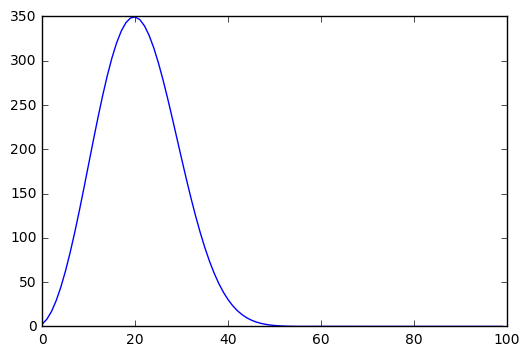

In [528]:
plt.plot(fobos.gradlog)

In [529]:
fobos.wlog[-1][0]

2.0004354798723791

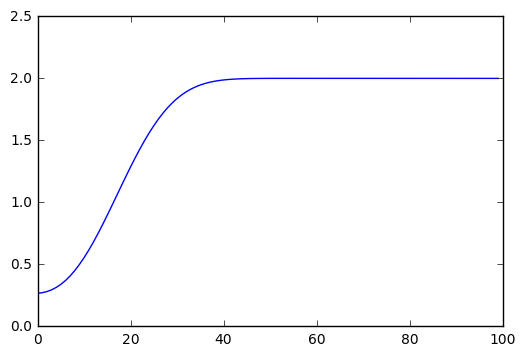

In [530]:
plt.plot(np.asarray(fobos.wlog)[:, 0])

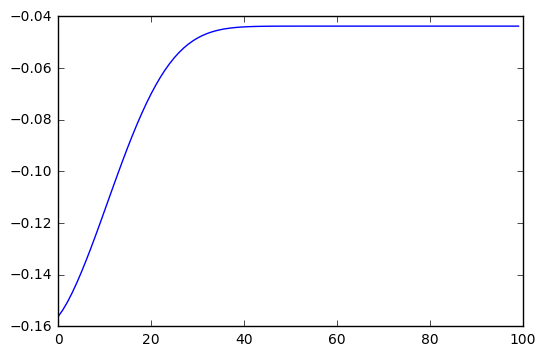

In [531]:
plt.plot(np.asarray(fobos.wlog)[:, 1])

In [537]:
real_coef = np.random.randn(10)

In [538]:
real_coef[-2] = 0
real_coef[1] = 0

In [539]:
real_coef

array([-2.27190773,  0.        ,  0.26147431,  1.04796244,  0.88744166,
       -1.67614298,  1.28986388,  0.42650058,  0.        ,  0.34654966])

<Container object of 3 artists>

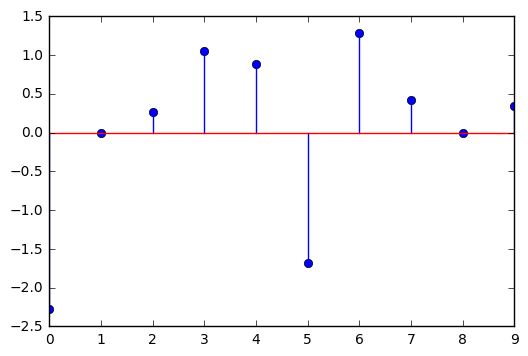

In [540]:
plt.stem(real_coef)

In [613]:
x = np.random.randn(100, 10)
y = x.dot(real_coef)

In [614]:
fobos = FOBOS(nitialization='random', lamda1= 1e-2, regularization='l1', initial_step=.15, with_log=True)
for i in range(np.shape(x)[0]):
    x_t = x[i, :]
    y_t = y[i]
    fobos.fit(x_t, y_t)

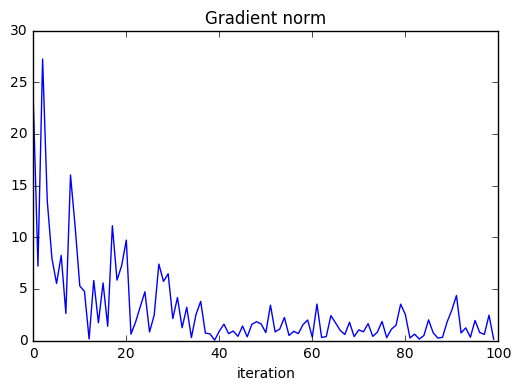

In [631]:
plt.plot(fobos.gradlog)
plt.title("Gradient norm")
plt.xlabel("iteration")

In [616]:
fobos.w

array([-2.23568058,  0.066474  ,  0.20646767,  0.84989947,  0.86416492,
       -1.46185254,  1.32687822,  0.30520896,  0.08362416,  0.30104822,
       -0.07246341])

In [626]:
w_diff = list(map(lambda cur:np.linalg.norm(cur[:-1] - real_coef), fobos.wlog))

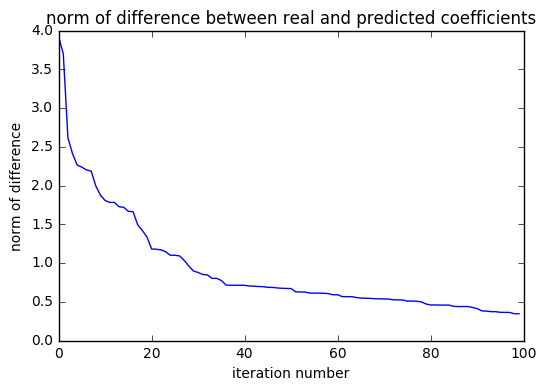

In [630]:
plt.plot(w_diff)
plt.title("norm of difference between real and predicted coefficients")
plt.xlabel("iteration number")
plt.ylabel("norm of difference")